# Travail pratique d'optimisation pour l'apprentissage

### Réalisé par MULAPI TITA Ketsia

__________________________________________________________

## 1) TP  Gradient projeté et gradient conditionnelle (aka Franke-Wolfe)

On cherche dans ce TP à illustrer le comportement de ces deux algos sur un prob
lème jouet

#### NOTE :

j'utilise numba juste pour accélérer l'éxécution de mes fonctions.

In [1]:
from numba import jit

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
plt.close("all")

@jit
def mesh(x_min,x_max,y_min,y_max, h = 0.1):

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return np.c_[xx.ravel(), yy.ravel()], xx, yy

La fonction objective que l'on cherche à optimiser est une fonction 2D
définie par sa Hessienne H, b et c.

In [4]:
H = np.array([[1,-0.5],[-0.5,4]])
b = np.array([2,1])
c = 3

@jit
def cout(X):
    if len(X.shape)==1:
        X = np.atleast_2d(X)
    n= X.shape[0]
    cout = np.zeros(n)
    for i in range(n):
        x = X[i,:]
        cout[i] = 0.5*x.T@H@x + x.T@b + c
    return cout

Afficher les courbes de niveau de cette fonction

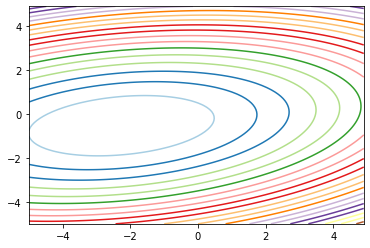

[[38.    37.955 37.92  ... 80.195 81.12  82.055]
 [36.37  36.32  36.28  ... 78.08  79.    79.93 ]
 [34.78  34.725 34.68  ... 76.005 76.92  77.845]
 ...
 [66.13  65.6   65.08  ... 61.28  61.72  62.17 ]
 [68.38  67.845 67.32  ... 63.045 63.48  63.925]
 [70.67  70.13  69.6   ... 64.85  65.28  65.72 ]]


In [7]:
# Z contient tout les points de la grille -5,5
Z, xx, yy  = mesh(-5,5,-5,5)

cost = cout(Z)
cost = cost.reshape(xx.shape)
plt.figure(1)
plt.contour(xx, yy, cost, 20, cmap=plt.cm.Paired)
plt.show()

print(cost)

Affichez sur cette figure les frontieres de la contraintes suivante

1.  la courbe $\|x\|_2 = 3$

Implémenter un algorithme de gradient projété, avec un backtracking du pas, pour ces deux contraintes 
et tracer l'évolution de $w$ sur ce graphe

In [8]:
def LeverException(f):
    raise Exception("Problème au niveau de la fonction ",f)

In [9]:
def contrainte(X):
    '''
    Cette fonction me permet de contraindre mon domaine à l'aide
    de l'équation d'un cercle x²+y²
    '''
    return X[:, 0]**2 + X[:,1]**2

In [10]:
def projection_boule(y, tho):
    '''
    On sait qu'on ne connait pas le bon lambda, on va alors se contenter de faire
    une projection sur une boule de rayon L, en utilisant une descente de gradient
    pour le trouver.
    Cette fonction permet donc de normraliser y, en ledivisant par sa norme
    '''
    norme_y = np.linalg.norm(y)
    if norme_y > tho:
        return y/norme_y*tho
    elif norme_y <= tho:
        return y
    return LeverException(projection_boule)

In [11]:
def gradient(X):
    '''
    Cette fonction permet de renvoyer le calcul du gradient de la focntion cout
    '''
    return H@X + b

In [12]:
def backtrack(x,grad,cost,crit,sigma0,c,rho):  
    '''
    cette focntion est notre premier code de backtracking,
    elle permet d'appliquer de recherche un point qui satisfait les conditions
    '''
    d = -grad
    i = 0
    sigma = sigma0
    max_iter = 100
    sigma_list = []
    flist = []
    compar = cost(x + sigma * d)
    cost_x = cost(x)
    sigma_list = [sigma]
    flist = [compar]
    
    while compar > cost_x + c * sigma * crit  and i < max_iter:
        sigma = rho * sigma
        compar = cost(x + sigma * d)
        sigma_list.append(sigma)
        flist.append(compar)
        i += 1
      
    return sigma  

In [13]:
def steepest_descent(x0,cost,gradient,method, proj_boule, tho,sigma0):
    '''
    On a alors besoin d'utiliser notre fnction de départ de steepest_descent, qui nous aidera,
    au bout de chaque itération à prendre un chemin de descente, tout en construisant une série
    de point et, afin de converger vers le minimum recherché.
    '''
    xlist = []
    flist = []
    nlist = []
    
    xk = np.copy(x0)
    
    xlist.append(xk)
    flist.append(cost(xk))
    nlist.append(np.linalg.norm(gradient(xk)))
    k = 0
    sigma = sigma0
    
    while nlist[-1] > 1e-6 and k < 100:
        d = -gradient(xk)
        sigma = method(xk,gradient(xk),cost,np.linalg.norm(gradient(xk)),sigma,c,rho)
        xk = xk + sigma*d
        xk = proj_boule(xk, tho)
        
        xlist.append(xk)
        flist.append(cost(xk))
        nlist.append(np.linalg.norm(gradient(xk)))
     
        k += 1  
    
    
    return xlist, flist, nlist

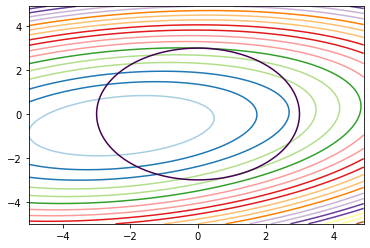

In [14]:
Z, xx, yy  = mesh(-5,5,-5,5)

cost = cout(Z)
cost = cost.reshape(xx.shape)
const = contrainte(Z).reshape(xx.shape)
tho = 3

plt.figure(2)
plt.contour(xx, yy, cost, 20, cmap=plt.cm.Paired)
plt.contour(xx, yy, const, 1, levels=[tho**2])

/tmp/ipykernel_29578/300700931.py:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cout" failed type inference due to: Cannot unify array(float64, 1d, C) and array(float64, 2d, C) for 'X.2', defined at /tmp/ipykernel_29578/300700931.py (9)

File "../../../tmp/ipykernel_29578/300700931.py", line 9:
<source missing, REPL/exec in use?>

During: typing of assignment at /tmp/ipykernel_29578/300700931.py (9)

File "../../../tmp/ipykernel_29578/300700931.py", line 9:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_29578/300700931.py:5: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cout" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../tmp/ipykernel_29578/300700931.py", line 9:
<source missing, REPL/exec in use?>

  @jit
/home/ketsia/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.p

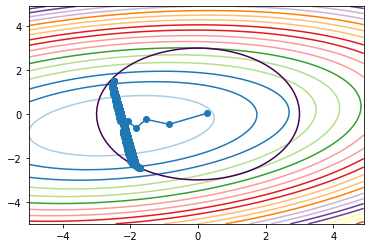

In [15]:
Z, xx, yy  = mesh(-5,5,-5,5)

cost = cout(Z)
cost = cost.reshape(xx.shape)
const = contrainte(Z).reshape(xx.shape)
tho = 3

plt.figure(2)
plt.contour(xx, yy, cost, 20, cmap=plt.cm.Paired)
plt.contour(xx, yy, const, 1, levels=[tho**2])


nb_iter = 100
w = np.random.randn(2)*3
m_cout = np.zeros(nb_iter)
mat_w = np.zeros((nb_iter,2))
c = 0.2
tho = 3
pas = 0.5
rho = 0.9


mat_w, m_cout, nlist = steepest_descent(w,cout,gradient,backtrack, projection_boule, tho,pas)
mat_w = np.array(mat_w)[1:,:].reshape((nb_iter, 2))
plt.plot(mat_w[:,0],mat_w[:,1],'o-')
plt.show()

## 2) Algorithme de Franke-Wolfe

On cherche à apprendre un modèle de régression sous contrainte de norme $\ell_1$. On cherche
donc à résoudre le probleme
$$
\min_w \frac{1}{2} \|y - Xw\|_2^2  \quad \text{sc} \quad \|w\|_1 \leq \tau
$$

en sachant que 
$$
z = \arg\min_z a^\top z \quad \|w\|_1 \leq \tau
$$
avec $z = -\tau sign(a_k) e_{i_k}$ et $i_k = \arg\max_k |a_k|$





In [16]:
import sklearn.datasets as datas

In [17]:
@jit
def get_data(data):
    '''
    Cette focntion pemret d'obtenir un jeux de données en X,y, dans la base sklearn
    '''
    if data=='boston':
        return datas.load_boston(True)
    elif data=='diabetes':
        return datas.load_diabetes(True)
    return LeverException(get_data)

In [42]:
# récupération des données
data = get_data('diabetes')
X, y = data[0],data[1]

1.   Implémenter l'algorithme de Franke-wolfe correspondant

In [126]:
# inserer votre code
@jit
def cout_Franck(X,w,y):
    '''
    Implémentation de la fonction cout donnée
    '''
    return 0.5*(np.linalg.norm(y-X@w)**2)

@jit
def gradient_Franck(X,w,y):
    '''
    le gradient de notre fonction cout
    '''
    return -X.T@(y-X@w)

@jit
def franke_wolfe(w0,X,y,tho,e,pas,nb_iter):
    '''
    L'algorithme de franckwolf, bas"e sur notre steepest descente l1
    '''
    k = 0
    wk = w0
    wlist = []
    flist = []
    zlist = []
    p = len(wk)
    while k < nb_iter:
        t = np.argmax(np.abs(gradient_Franck(X,wk,y)))
        e = np.zeros(p)
        e[t] = 1
        z = -tho*np.sign(gradient_Franck(X,wk,y))*e
        zlist.append(z)
        wk = (1 - pas)*wk + pas*z
        flist.append(cout_Franck(X,wk,y))
        wlist.append(wk)
        k += 1
    return wlist,flist,zlist

In [20]:
@jit
def contrainte_l1(X):
    '''
    Cette fonction me permet de contraindre mon domaine afin
    d'en faire un carré
    '''
    return np.abs(X[:,0]) + np.abs(X[:,1])

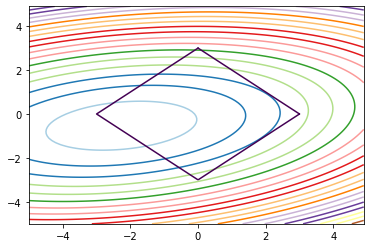

In [21]:
d_2 = X.shape[1]
w1 = np.random.randn(2)*3
gamma = 2/(nb_iter + 1)
e = np.zeros(d_2)

Z, xx, yy  = mesh(-5,5,-5,5)

cost = cout(Z)
cost = cost.reshape(xx.shape)
const = contrainte_l1(Z).reshape(xx.shape)
tho = 3


plt.figure(1)
plt.contour(xx, yy, cost, 20, cmap=plt.cm.Paired)
plt.contour(xx, yy, const, 1, levels = [tho])

### ici, je test mon algo sur un problème simple : exercice rpécédent


ok


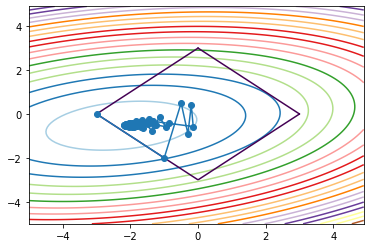

In [139]:
d_2 = X.shape[1]
w1 = np.random.randn(2)*3
gamma = 2/(nb_iter + 1)
e = np.zeros(d_2)

Z, xx, yy  = mesh(-5,5,-5,5)

# cout problème 1
cost = cout(Z)
cost = cost.reshape(xx.shape)
# contrainte problème 2
const = contrainte_l1(Z).reshape(xx.shape)
tho = 3


plt.figure(2)

nb_iter = 100
m_cout = np.zeros(nb_iter)

k = 0
wk = w1
mat_w = []
m_cout = []
p = len(wk)
print("ok")
while k < nb_iter:
    t = np.argmax(np.abs(gradient(wk)))
    e = np.zeros(p)
    e[t] = 1
    z = -tho*np.sign(gradient(wk))*e
    pas = 2/(k + 2) #gamma de wikipedia
    wk = (1 - pas)*wk + pas*z
    m_cout.append(cout(wk))
    mat_w.append(wk)
    k += 1

mat_w = np.array(mat_w)[:,:].reshape((nb_iter,2))
plt.plot(mat_w[:,0], mat_w[:,1],'o-')
plt.contour(xx, yy, cost, 20, cmap=plt.cm.Paired)
plt.contour(xx, yy, const, 1, levels = [tho])
plt.show()

2.   Appliquer cette algorithme aux données diabetes du TP de regression de ML.

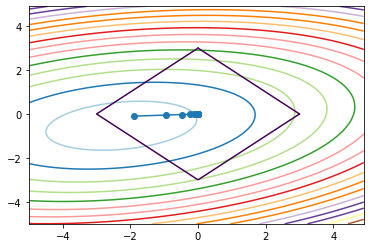

In [150]:
Z, xx, yy  = mesh(-5,5,-5,5)

# cout problème 1
cost = cout(Z)
cost = cost.reshape(xx.shape)
# contrainte problème 2
const = contrainte_l1(Z).reshape(xx.shape)

d = X.shape[1]
nb_iter = 100
w = np.random.randn(d)*3
m_cout = np.zeros(nb_iter)
#tau = 
e = np.zeros(d)
tho = 3
pas = 0.5
   
mat_w,m_cout,zlist =  franke_wolfe(w,X,y,tho,e,pas,nb_iter)

mat_w = np.array(mat_w)[:,:].reshape((nb_iter,d))
plt.plot(mat_w[:,0], mat_w[:,1],'o-')
plt.contour(xx, yy, cost, 19, cmap=plt.cm.Paired)
plt.contour(xx, yy, const, 1, levels = [tho])
plt.show()

3.   Analyser la forme du minimiseur en fonction de $\tau$

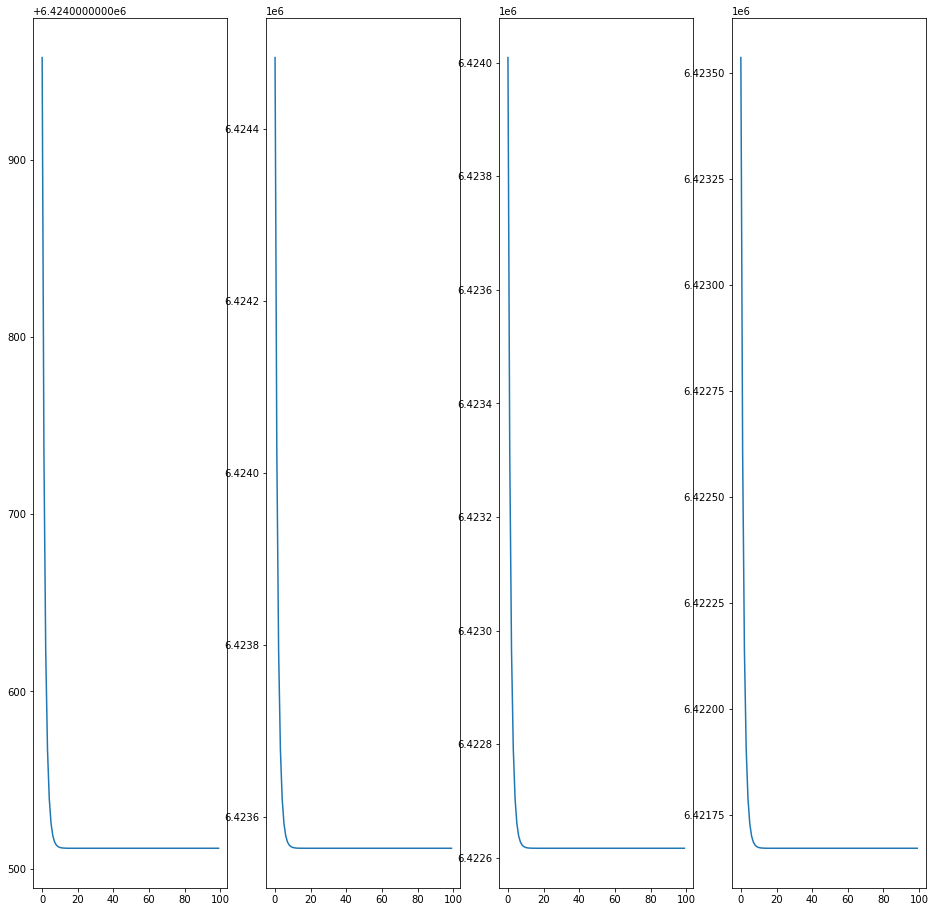

In [147]:
d = X.shape[1]
nb_iter = 100
w = np.random.rand(d)*0.04
m_cout = np.zeros(nb_iter)
e = np.zeros(d)
fig = plt.figure(1,figsize=(16,16))
tau_list = range(1,5)


for i in range (len(tau_list)): #variation de rho
    tau_ = tau_list[i]
    e = np.zeros(d)
    m_cout = np.zeros(nb_iter)
    fig = plt.subplot(1,len(tau_list),i+1)
    mat_w,m_cout,zlist =  franke_wolfe(w,X,y,tau_,e,pas,nb_iter)
    mat_w = np.array(mat_w)[:,:].reshape((nb_iter,d))
    fig.plot(range(len(m_cout)),m_cout)

4.   Commenter la solution

On voit qu'il n'est pas aussi simple d'atteindre le minimum avec Franke Wolfe, contrairement à la descente de gradient qui est une méthode sûre.

## 3) TP QP par un algorithme de points intérieurs

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC

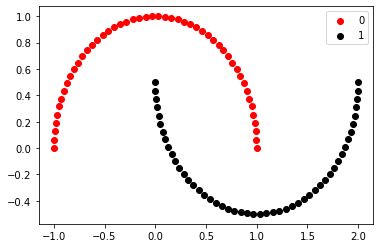

In [162]:
n_train = 100
X,y = make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)

# afficher les données d'apprentissage sur un plot avec une couleur par classe
# inserer votre code ici
def coul(classe):
    if classe==0:
        return 'red'
    else :
        return 'black'

classes = np.unique(y)
def get_classe():
       return X[np.where(c == y)[0]]

for c in range(len(classes)):
    plt.scatter(X[np.where(c == y)[0]][:, 0], X[np.where(c == y)[0]][:, 1], label=classes[c], color=coul(classes[c]))
    plt.legend()

In [166]:
#%% SVM dual 
C =1000
N = X.shape[0]

from sklearn.metrics.pairwise import rbf_kernel
gamma = 1
N = X.shape[0]
K = rbf_kernel(X,gamma = gamma)
yb = y.reshape(N,1)
P = K*(yb@yb.T)

clf = SVC(C=C,kernel='precomputed')
clf.fit(K, y)
indice_SV = clf.support_
alpha_sk = clf.dual_coef_[0]
b_sk = clf.intercept_

# construire le vecteur solution alpha_0

print(alpha_sk)
#alpha0 = np.zeros((alpha_sk))
#print(alpha0)

# calculer la valeur objective optimale du problème QP obtenu par ce solveur SVM
# et afficher le résultat




[-7.99731966 -1.89402167 -2.76165488 -2.13944953 -0.0917733  -1.73475256
  8.00142783  2.04777625  1.73299679  1.98048075  2.62539222  0.23089776]


On s'interesse au problème
$$
\min_{\alpha} \frac{1}{2} \alpha^\top P \alpha + q^\top \alpha  \quad \text{ } \quad \text{sc } \quad \alpha^\top y = 0  \text{ et } \alpha \geq 0
$$

In [167]:
def cout_QP(alpha, P, q):
    return 1/2 * alpha.T@P@alpha + q.T@alpha

def gradient_QP(alpha, P, q):
    return P@alpha + q

In [168]:
# projection QP
def projection_QP():
    raise NotImplementedError

# ici on peut utiliser une apprie : descente de gradient, newton, newton_l1
# le plus simple c peut être uen descente de gradient ou un newton
def steepest_descent_QP():
    raise NotImplementedError    

# Algorithme de point intérieur 
def QP(P,q,l,u):
    w = np.random.rand(P.shape[0],1)
    c = 0.5    
    beta = 1.5
    wlist,flist,zlist = steepest_descent_QP(w,c,beta,cout_QP,gradient_QP,backtrack, projection_QP)   
    return flist, projection_QP()

In [169]:

# construction du problème et des matrices associés

q = -np.ones(N)
b = np.array([0.0])
A = y.reshape(1,N)

# initialization du point intérieur

alpha = np.random.rand(N)*1e-2
nb_constraint = A.shape[0]

ll = np.ones((nb_constraint,1)) # multiplicateur de Lagrange
s = ((P@alpha   + q).reshape(N,1) - A.T@ ll).reshape(N)
s = np.where(s < 0.000001, 1e-16, s)  # on garde que les parties positives pour que s soit faisable

print('cout init',0.5*alpha.T@P@alpha + q.T@alpha)


cout init -0.483792707446335


In [ ]:

for i in range(1000):
    tau = x@s/N
    Sk = np.diag(s)
    Xk = np.diag(x)
    cout = 0.5*x.T@P@x + q.T@x
    # construire les lignes de la Jacobienne
    # inserer votre code ici
    print(i, cout,tau)
    J1 = np.hstack((P, -A.T, -np.eye(N)))
    J2 = np.hstack((A, np.zeros((nb_constraint,1)), np.zeros((nb_constraint,N))))
    J3 = np.hstack((Sk, np.zeros((N,1)), Xk))
    
    J = np.vstack((J1,J2,J3))  
    
    b1 = np.zeros((N,1))
    b1 = (P@x  -s + q).reshape(N,1) - A.T@ ll 
    b2 = (A@x - b ).reshape(nb_constraint,1)
    b3 = - sigma*tau*np.ones((N,1)) + (s*x).reshape(N,1)
    
    second_membre = np.vstack((b1,b2,b3))
    
    # résoudre le problème
    S = np.linalg.solve(J, -second_membre)
    
    # extraire les directions pour chaque partie
    
    dx = projection_QP()
    dy = projection_QP()
    ds = projection_QP()
    
    # définir le pas optimal 
    # inserer votre code ici
    step = backtrack
    
    # mise à jour
    x = x + step*dx
    ll = ll + step*dy
    s = s + step*ds



1.   Montrer que le cout décroit correctement
2.   Comparer la solution alpha avec celui obtenu par le solveur SVM
3.   Améliorer la boucle pour avoir une condition de sortie plus pertinente





Modifier les matrices proposées en entrée de cette algorithme afin de résoudre le problème complet
$$
\min_{\alpha} \frac{1}{2} \alpha^\top P \alpha + q^\top \alpha  \quad \text{ } \quad \text{sc } \quad \alpha^\top y = 0  \text{ et } C \geq \alpha \geq 0
$$